In [0]:
import pandas as pd
from collections import deque
import random; random.seed(1234)
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization, CuDNNGRU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint
from tensorflow.keras import regularizers
import time
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt

## Introduction

For this project, we are trying to predict the future prices of crytocurrency using their history prices with recurrent neural networks in order to decide whether to buy in a certain crytocoin at a certain time. The data we'll be using is Open, High, Low, Close, Volume data for Bitcoin, Ethereum, Litecoin and Bitcoin Cash. We get our data from this tutorial: https://pythonprogramming.net/cryptocurrency-recurrent-neural-network-deep-learning-python-tensorflow-keras/

To predict the future prices, we're going to only be focused on the Close and Volume columns. The Close column measures the final price at the end of each interval. In this case, these are 1 minute intervals. So, at the end of each minute, what was the price of the asset. The Volume column is how much of the asset was traded per each interval, in this case, per 1 minute.

The theory being that these cryptocoins all have relationships with eachother. Therefore, we decide to predict the future movements of one crytocurrency, for example Bitcoin, by analyzing the last 60 minutes of prices and volumes for all 4 of these coins.

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 3  # how far into the future are we trying to predict
RATIO_TO_PREDICT = "BTC-USD"
EPOCHS = 10  # how many passes through our data
BATCH_SIZE = 64  
# NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

In [0]:
def classify(current, future):
    if float(future) > float(current):  # if the future price is higher than the current, that's a buy, or a 1
        return 1
    else:  # otherwise... it's a 0!
        return 0


def preprocess_df(df):
    df = df.drop("future", 1)  # don't need this anymore.

    for col in df.columns:  # go through all of the columns
        if col != "target":  # normalize all ... except for the target itself!
            df[col] = df[col].pct_change()  # pct change "normalizes" the different currencies (each crypto coin has vastly diff values, we're really more interested in the other coin's movements)
            df.dropna(inplace=True)  # remove the nas created by pct_change
            df[col] = preprocessing.scale(df[col].values)  # scale between 0 and 1.

    df.dropna(inplace=True)  # cleanup again... jic.


    sequential_data = []  # this is a list that will CONTAIN the sequences
    prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

    for i in df.values:  # iterate over the values
        prev_days.append([n for n in i[:-1]])  # store all but the target
        if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
            sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!

    random.shuffle(sequential_data)  # shuffle for good measure.

    buys = []  # list that will store our buy sequences and targets
    sells = []  # list that will store our sell sequences and targets

    for seq, target in sequential_data:  # iterate over the sequential data
        if target == 0:  # if it's a "not buy"
            sells.append([seq, target])  # append to sells list
        elif target == 1:  # otherwise if the target is a 1...
            buys.append([seq, target])  # it's a buy!

    random.shuffle(buys)  # shuffle the buys
    random.shuffle(sells)  # shuffle the sells!

    lower = min(len(buys), len(sells))  # what's the shorter length?

    buys = buys[:lower]  # make sure both lists are only up to the shortest length.
    sells = sells[:lower]  # make sure both lists are only up to the shortest length.

    sequential_data = buys+sells  # add them together
    random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.

    X = []
    y = []

    for seq, target in sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X), y  # return X and y...and make X a numpy array!



## Data Preprocess

To start with, we will merge the close price and volume data of the four cryptocurrencies into one data set. Because we believe there are some relationships among their prices, putting the close prices of other cryptocoins into our training data will help predict the price of the crytocurrency we are interested in. 

Then, we will deal with the missing values in our data set. We decide to use the "ffill" method in Pandas to filling in the missing values that propagate the last valid observation forward. For the missing values that cannot be filled with the method purposed above, we will directly delete them from the dataset.

Next, we need to create a target column that indicates whether to buy in the crytocoin or not. To do this, we need to know which price we're trying to predict. We also have to decide how far out we want to predict. 

We'll go with Bitcoin for now. Knowing how far out we want to predict probably also depends how long our sequences are. If our sequence length is 3 (minutes), we probably can't easily predict out 10 minutes. However, if our sequence length is 300, 10 might not be as hard. Here, we decide to choose the same parameters as in the tutorial, which are sequence length of 60, and a future prediction out of 3. 

Therefore, the label or target we are trying to predict is now a binary classifier. Given the transaction data from the past 60 minutes, if we predict the price of Bitcoin will be higher 3 minutes later than now, our model will output 1, otherwise 0.

To do this, we decide to the add the column of "future" and "target" in the dataframe that indicates the future price and the target we are trying to predict.

Now we can take a look at the data set after preprocessing:

In [6]:
main_df = pd.DataFrame() # begin empty

ratios = ["BTC-USD", "LTC-USD", "BCH-USD", "ETH-USD"]  # the 4 ratios we want to consider
for ratio in ratios:  # begin iteration

    ratio = ratio.split('.csv')[0]  # split away the ticker from the file-name
    dataset = f'{ratio}.csv'  # get the full path to the file.
    df = pd.read_csv(dataset, names=['time', 'low', 'high', 'open', 'close', 'volume'])  # read in specific file

    # rename volume and close to include the ticker so we can still which close/volume is which:
    df.rename(columns={"close": f"{ratio}_close", "volume": f"{ratio}_volume"}, inplace=True)

    df.set_index("time", inplace=True)  # set time as index so we can join them on this shared time
    df = df[[f"{ratio}_close", f"{ratio}_volume"]]  # ignore the other columns besides price and volume

    if len(main_df)==0:  # if the dataframe is empty
        main_df = df  # then it's just the current df
    else:  # otherwise, join this data to the main one
        main_df = main_df.join(df)

main_df.fillna(method="ffill", inplace=True)  # if there are gaps in data, use previously known values
main_df.dropna(inplace=True)


main_df['future'] = main_df[f'{RATIO_TO_PREDICT}_close'].shift(-FUTURE_PERIOD_PREDICT)
main_df['target'] = list(map(classify, main_df[f'{RATIO_TO_PREDICT}_close'], main_df['future']))

main_df.dropna(inplace=True)        

main_df.head()

,BTC-USD_close,BTC-USD_volume,LTC-USD_close,LTC-USD_volume,BCH-USD_close,BCH-USD_volume,ETH-USD_close,ETH-USD_volume,future,target
time,,,,,,,,,,
1528968720,6487.379883,7.706374,96.660004,314.387024,870.859985,26.856577,486.01001,26.019083,6479.979980,0
1528968780,6479.410156,3.088252,96.570000,77.129799,870.099976,1.124300,486.00000,8.449400,6480.000000,1
1528968840,6479.410156,1.404100,96.500000,7.216067,870.789978,1.749862,485.75000,26.994646,6477.220215,0
1528968900,6479.979980,0.753000,96.389999,524.539978,870.000000,1.680500,486.00000,77.355759,6480.000000,1
1528968960,6480.000000,1.490900,96.519997,16.991997,869.989990,1.669014,486.00000,7.503300,6479.990234,0


## EDA

Since we are studying the time series data, we really want to know how the prices of each cryptocurrencies change through time, and we will make some visualization plots of their prices.

From the line plots of the four cryptocurrencies' prices, we can see that their prices seem to fluctuate in the same way. Therefore, it proves our hypothesis that the prices of these four cryptocurrencies have some kind correlation, and it makes sense to include the prices of other three cryptocurrencies in our prediction model.

In [7]:
ts_df = main_df[['BTC-USD_close','LTC-USD_close',
                  'BCH-USD_close','ETH-USD_close']]
ts_df.index = ts_df.index.map(lambda x:
                              datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
ts_df.head()

,BTC-USD_close,LTC-USD_close,BCH-USD_close,ETH-USD_close
time,,,,
2018-06-14 09:32:00,6487.379883,96.660004,870.859985,486.01001
2018-06-14 09:33:00,6479.410156,96.570000,870.099976,486.00000
2018-06-14 09:34:00,6479.410156,96.500000,870.789978,485.75000
2018-06-14 09:35:00,6479.979980,96.389999,870.000000,486.00000
2018-06-14 09:36:00,6480.000000,96.519997,869.989990,486.00000


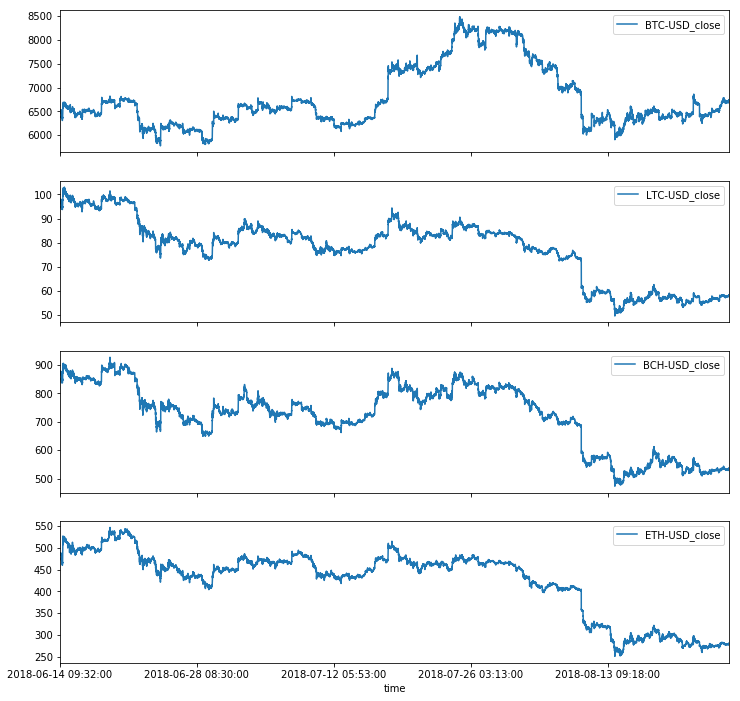

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex = True, figsize=(12,12))

p1 = ts_df[['BTC-USD_close']].plot(ax=axes[0])
p2 = ts_df[['LTC-USD_close']].plot(ax=axes[1])
p3 = ts_df[['BCH-USD_close']].plot(ax=axes[2])
p4 = ts_df[['ETH-USD_close']].plot(ax=axes[3])
plt.show()

From the histogram of the cryptocoins' prices, we can see that there is no obvious distribution patterns that they follow.

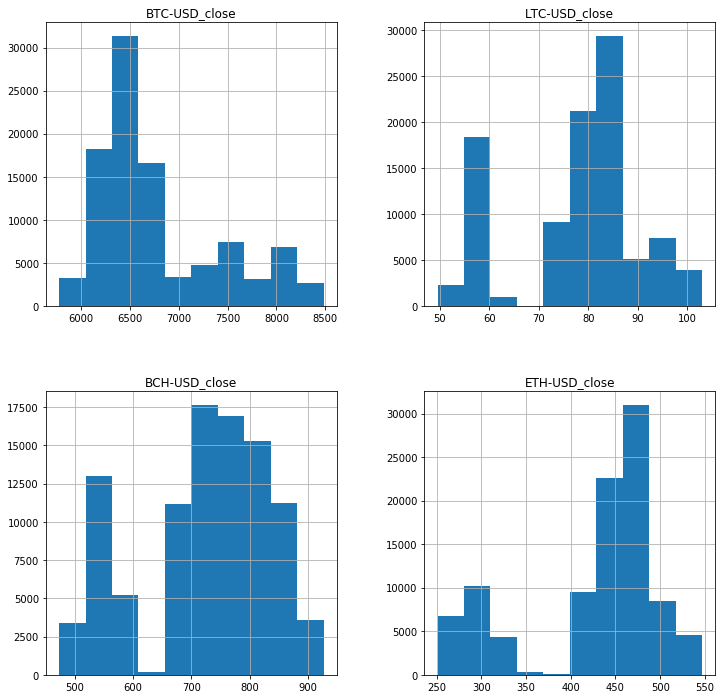

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

p1 = ts_df[['BTC-USD_close']].hist(ax=axes[0,0])
p2 = ts_df[['LTC-USD_close']].hist(ax=axes[0,1])
p3 = ts_df[['BCH-USD_close']].hist(ax=axes[1,0])
p4 = ts_df[['ETH-USD_close']].hist(ax=axes[1,1])
plt.show()

In order to have a better sense of the price of Bitcoin, we will make the lag plot and autoregression plot of Bitcoin prices to explore more imformation. 

Here's a little information on lag plot and autoregression:

**Lag Plot:** Previous observations in a time series are called lags, with the observation at the previous time step called lag1, the observation at two time steps ago lag2, and so on. Pandas has a built-in function for exactly this called the lag plot. It plots the observation at time t on the x-axis and the lag1 observation (t+1) on the y-axis. More points tighter in to the diagonal line suggests a stronger relationship and more spread from the line suggests a weaker relationship.

**Autoregression Plot:** We can quantify the strength and type of relationship between observations and their lags. In statistics, this is called correlation, and when calculated against lag values in time series, it is called autocorrelation (self-correlation). Correlation values, called correlation coefficients, can be calculated for each observation and different lag values. Once calculated, a plot can be created to help better understand how this relationship changes over the lag.

The lag plot of Bitcoin price below shows a relatively strong positive correlation between observations and their lag1 values. This is actually good for our RNN prediction model, because our model is trying to predict the future price of Bitcoin based on its recent history prices.

Because there is no obivious patterns in the autoregression plot, we can conclude that there's no obvious seasonality in the Bitcoin prices.

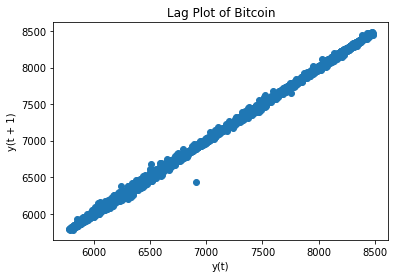

In [24]:
from pandas.plotting import lag_plot

lag_plot(ts_df[['BTC-USD_close']])
plt.title("Lag Plot of Bitcoin")
plt.show()

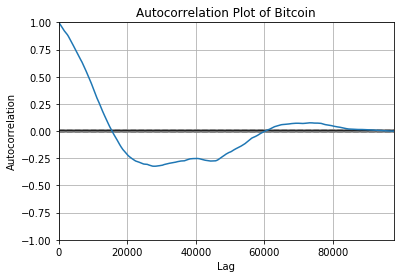

In [25]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(ts_df[['BTC-USD_close']])
plt.title("Autocorrelation Plot of Bitcoin")
plt.show()

## Model Building

For this part, we prepare our price data to modeling and start building our recurrent neural network models to predict whether or not to buy in Bitcoin at a specific time based on history prices and transaction data of the four cryptocurrencies.

We will start with spliting the data set into a training set and a validation set. The reason for having a validation set is to evaluate the performance of our model on new data that it has not seen before. Additionally, since we are dealing with sequential data, the order of the observations matters. Therefore, we cannot choose randomly from the original data set to get our validation set. Instead, we decide to choose the most recent 5 percent of our data as the validation set.

We will start with the model in the tutorial (https://pythonprogramming.net/crypto-rnn-model-deep-learning-python-tensorflow-keras/?completed=/balancing-rnn-data-deep-learning-python-tensorflow-keras/) as our baseline model. 

The model consists 3 LSTM layers and 2 dense layers. The last layer of the model is a dense layer of 2 units with the activation function "softmax". The architecture of the baseline model is as below:

In [12]:
## here, split away some slice of the future data from the main main_df.
times = sorted(main_df.index.values)
last_5pct = sorted(main_df.index.values)[-int(0.05*len(times))]

validation_main_df = main_df[(main_df.index >= last_5pct)]
main_df = main_df[(main_df.index < last_5pct)]

train_x, train_y = preprocess_df(main_df)
validation_x, validation_y = preprocess_df(validation_main_df)

print(f"train data: {len(train_x)} validation: {len(validation_x)}")
print(f"Dont buys: {train_y.count(0)}, buys: {train_y.count(1)}")
print(f"VALIDATION Dont buys: {validation_y.count(0)}, buys: {validation_y.count(1)}")

train data: 83156 validation: 4478
Dont buys: 41578, buys: 41578
VALIDATION Dont buys: 2239, buys: 2239


In [22]:
model = Sequential()
model.add(CuDNNLSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))


opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_3 (CuDNNLSTM)     (None, 60, 128)           70656     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 60, 128)           512       
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 60, 128)           132096    
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
batch_normalization_v1_7 (Ba (None, 60, 128)           512       
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 128)               132096    
__________

We will go ahead and train the baseline model with our training data. The model trained for 10 epochs has an accuracy of 0.5529 on the validation set. This accuracy may seem very low compared to the accuracy of classification models for image recognition or sentiment analysis. However, for financial data, we believe any accuracy significantly above 50% would be a decent prediction. Therefore, we consider the baseline RNN prediction model to have decent performance.

However, the accuracy and loss plots of the training set and validation set indicates that there is an overfitting problem with this baseline model. Because the accuracy of this model tends to decrease as the number of epochs increases. 

Therefore, we will start with this baseline model and try to improve it by handling the overfitting problem.

In [23]:
# Train model
original_history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    # callbacks=[tensorboard, checkpoint],
)

# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 83156 samples, validate on 4478 samples
Epoch 1/10
83156/83156 [==============================] - 26s 312us/sample - loss: 0.7036 - acc: 0.5276 - val_loss: 0.6834 - val_acc: 0.5523
Epoch 2/10
83156/83156 [==============================] - 23s 280us/sample - loss: 0.6796 - acc: 0.5646 - val_loss: 0.6762 - val_acc: 0.5708
Epoch 3/10
83156/83156 [==============================] - 23s 279us/sample - loss: 0.6748 - acc: 0.5782 - val_loss: 0.6745 - val_acc: 0.5712
Epoch 4/10
83156/83156 [==============================] - 24s 291us/sample - loss: 0.6725 - acc: 0.5842 - val_loss: 0.6778 - val_acc: 0.5670
Epoch 5/10
83156/83156 [==============================] - 24s 288us/sample - loss: 0.6701 - acc: 0.5894 - val_loss: 0.6750 - val_acc: 0.5732
Epoch 6/10
83156/83156 [==============================] - 24s 284us/sample - loss: 0.6660 - acc: 0.5955 - val_loss: 0.6745 - val_acc: 0.5706
Epoch 7/10
83156/83156 [==============================] - 24s 285us/sample - loss: 0.6605 - acc: 0.6036 -

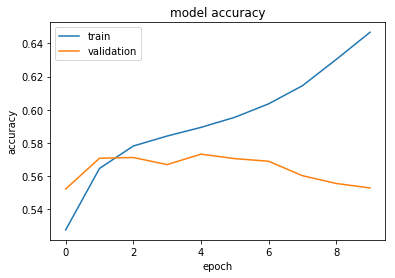

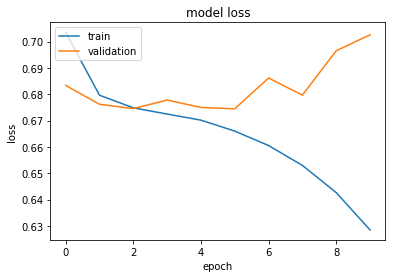

In [26]:
plt.plot(original_history.history['acc'])
plt.plot(original_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.plot(original_history.history['loss'])
plt.plot(original_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

We made the following efforts to fight the overfitting problems with the baseline model:

**1. Replace the LSTM layers with GRU layers.** 

Because GRU tends to be more efficient than LSTM (according to this paper: https://arxiv.org/pdf/1412.3555v1.pdf), and we can get a good performance with less epochs using GRU. The less epochs we need to fit our model, the less likely for our model to overfit.

**2. Increase the dropout rate in certain layer.** 

Dropout refers to removing each neuron independently with probability p and training the reduced network on a mini-batch of samples. Repeat with a freshly sampled subset on the next mini-batch. Dropout reduces overfitting by preventing the neural network from relying too heavily on specific pathways or individual neurons, and it’s remarkably effective. By increase the dropout rate, we make the model less likely to be overfitting. In our baseline model, there is one layer with the dropout rate of 0.1. For our new model, we decide to increase the dropout rate to 0.2.

**3. Add L2 regularizers to our model** 

Regularization is a way to fight overfitting by adding a term to penalize large weights in the objective function, and L2 regularization is when the penalty is in proportion to the square root of the sum of the squares of the weights. By penalizing the large weights of our recurrent neural network model, we can reduce the complexity of our model and get a model that performs better on unseen data.

**4. Early Stopping**

Early stopping is the idea of holding out a portion of the training data—called validation data—and halting the training process once the loss or accuracy stops improving. For example, we might stop when we reach a fixed number of steps after the last time a record minimum loss was reached (and then revert to the last record minimum). Here, we set the number of epochs with no improvement after which training will be stopped to be 3 by calling the EarlyStopping callback functions in Keras.

After making the modifications mentioned above, we get an improved model with the architecture as below:

In [32]:
model = Sequential()
model.add(CuDNNGRU(128, 
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(train_x.shape[1:]),
                   return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNGRU(128, kernel_regularizer=regularizers.l2(0.001),
                   return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNGRU(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))


opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

callbacks = [keras.callbacks.EarlyStopping(monitor = "val_loss",
                                           patience = 3,
                                           mode = 'max')]


model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_9 (CuDNNGRU)       (None, 60, 128)           52992     
_________________________________________________________________
dropout_20 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
batch_normalization_v1_15 (B (None, 60, 128)           512       
_________________________________________________________________
cu_dnngru_10 (CuDNNGRU)      (None, 60, 128)           99072     
_________________________________________________________________
dropout_21 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
batch_normalization_v1_16 (B (None, 60, 128)           512       
_________________________________________________________________
cu_dnngru_11 (CuDNNGRU)      (None, 128)               99072     
__________

The final results of our model show that the model after our improvement has an accuracy of 0.5803 on the validation set which higher than the validation accuracy of our baseline model by approximately 2.7%. Besides, with the techniques against overfitting mentioned above, our model achieve this validation accuracy with only 4 epochs and stops early to prevent the model from overfitting the training data. The accuracy and loss plots of the training set and validation set are below:

In [33]:
# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    callbacks=callbacks
)

# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 83156 samples, validate on 4478 samples
Epoch 1/10
83156/83156 [==============================] - 26s 309us/sample - loss: 0.7842 - acc: 0.5462 - val_loss: 0.7073 - val_acc: 0.5594
Epoch 2/10
83156/83156 [==============================] - 23s 279us/sample - loss: 0.6923 - acc: 0.5724 - val_loss: 0.6808 - val_acc: 0.5820
Epoch 3/10
83156/83156 [==============================] - 23s 279us/sample - loss: 0.6823 - acc: 0.5756 - val_loss: 0.6828 - val_acc: 0.5654
Epoch 4/10
83156/83156 [==============================] - 24s 290us/sample - loss: 0.6815 - acc: 0.5765 - val_loss: 0.6809 - val_acc: 0.5804
Test loss: 0.6809207949589384
Test accuracy: 0.580393


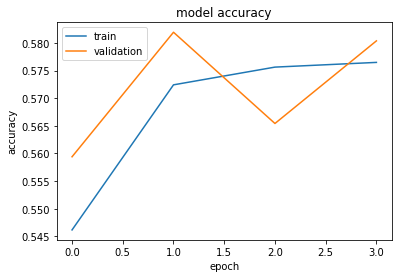

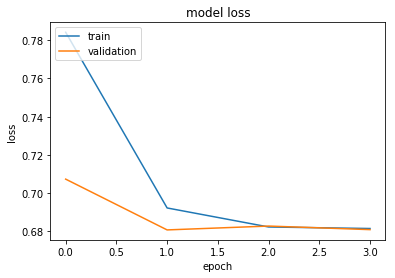

In [34]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Conclusion

To sum up, for this project, we build RNN models to predict whether or not to buy in Bitcoin at a specific time given the history prices and transactions of the four cryptocurrencies. We first clean and preprocess the price data and make some visualizations of the data to get a sense of training data. Next, we prepare the data for model building and starts with the model in the tutorial as our baseline model. However, our baseline model shows overfitting problems and we improve the baseline model in various ways to tackle with overfitting. Finally, we get a RNN prediction model using GRU layers with the accuracy of 58.03% on the validation set. Even though the accuracy may seem low compared to the accuracy of classification models for image recognition or sentiment analysis. However, for financial data, we believe any accuracy significantly above 50% would be a decent prediction. Therefore, we consider our final RNN prediction model to have a very good performance.